In [7]:
import numpy as np
from scipy.stats import logistic
import torch
from torch.utils.data import TensorDataset, DataLoader
import import_ipynb
from base.models import *
import torch.optim as optim
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [8]:
train_loss_dic = {}
occCorr_dic = {}
detCorr_dic = {}
nCovars = 10

In [9]:
# Generate synthetic dataset
for nSites in [100,1000]:
    for nVisits in [1,3,10]:
        print(nSites, nVisits)
        occCoeffs = np.random.uniform(-1,1,nCovars)
        detCoeffs = np.random.uniform(-1,1,nCovars)
        occCovars = np.random.normal(0,2,nSites*nCovars).reshape(nSites,nCovars)
        detCovars = np.random.normal(0,2,nSites*nVisits*nCovars).reshape(nSites,nVisits,nCovars)
        occProbs = logistic.cdf(np.dot(np.square(occCovars),occCoeffs))
        detProbs = logistic.cdf(np.dot(np.square(detCovars),detCoeffs))
        Ztrue = np.random.binomial(1, p=occProbs)
        detHists = np.random.binomial(1, p=detProbs)
        for i in range(len(Ztrue)):
            detHists[i,] = detHists[i,] * Ztrue[i]
        
        # Convert to torch.tensor
        x_train = torch.tensor(occCovars, dtype=torch.float32)
        w_train = torch.tensor(detCovars, dtype=torch.float32)
        y_train = torch.tensor(detHists, dtype=torch.float32)
        occ_train = torch.tensor(occProbs, dtype=torch.float32)
        det_train = torch.tensor(detProbs, dtype=torch.float32)
        
        # Train a model
        # For mini batches
        params = {'batch_size': len(x_train),
              'shuffle': True,
              'num_workers': 1}
        dataset = TensorDataset(x_train, w_train, y_train, \
                    torch.tensor(np.array(occ_train), dtype=torch.float32), \
                    torch.tensor(np.array(det_train).reshape(x_train.shape[0], nVisits), \
                                 dtype=torch.float32))  
        dataloader = DataLoader(dataset, **params)

        # Model selection
        torch.manual_seed(0)
        nN = 32
        lr = 0.001
        n_epoch = 1000
        model = StatEcoNet_H1(nCovars, nCovars, nN)

        # Set an optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Start training a model
        train_loss_hist = []
        occCorr_hist = []
        detCorr_hist = []
        for i in tqdm(range(n_epoch)):    
            train_batch_loss = []    
            train_occ_true = []
            train_det_true = []
            train_occ_pred = []
            train_det_pred = []
            train_y_true = []
            for i_batch, xy in enumerate(dataloader):
                # load a minibatch
                x_tr, w_tr, y_tr, occ_tr, det_tr = xy   
                train_y_true.extend(list(torch.flatten(y_tr).detach().numpy()))
                train_occ_true.extend(list(torch.flatten(occ_tr).detach().numpy()))
                train_det_true.extend(list(torch.flatten(det_tr).detach().numpy()))

                # Train a model
                model.train()
                optimizer.zero_grad()
                psi_hat_train, p_hat_train = model(x_tr, w_tr)
                train_occ_pred.extend(\
                            list(torch.flatten(psi_hat_train).detach().numpy()))
                train_det_pred.extend(\
                            list(torch.flatten(p_hat_train).detach().numpy()))

                # Compute training loss
                loss = my_loss_function(y_tr, psi_hat_train, p_hat_train, \
                                        x_tr.shape[0], nVisits)
                train_batch_loss.append(loss.item())        
                loss.backward()
                optimizer.step()

            # After learning all samples
            assert np.sum(train_y_true) == torch.sum(y_train)

            train_loss_hist.append(np.mean(train_batch_loss))

            # Compute correlation on prob.
            occCorr = pearsonr(train_occ_true, train_occ_pred)[0]
            detCorr = pearsonr(train_det_true, train_det_pred)[0]
            occCorr_hist.append(occCorr)
            detCorr_hist.append(detCorr)
            
        train_loss_dic[(nSites, nVisits)] = train_loss_hist
        occCorr_dic[(nSites, nVisits)] = occCorr_hist
        detCorr_dic[(nSites, nVisits)] = detCorr_hist

100 1



100 3



100 10



1000 1



1000 3



1000 10


In [10]:
detCorr_dic.keys()

dict_keys([(100, 1), (100, 3), (100, 10), (1000, 1), (1000, 3), (1000, 10)])

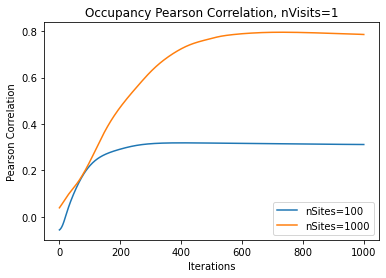

In [11]:
nVisits = 1
nSites = 100
plt.plot(occCorr_dic[(nSites, nVisits)], label='nSites='+str(nSites))
nSites = 1000
plt.plot(occCorr_dic[(nSites, nVisits)], label='nSites='+str(nSites))

plt.title("Occupancy Pearson Correlation, nVisits=" + str(nVisits))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

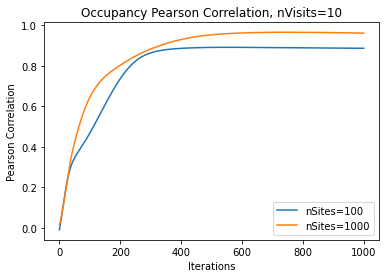

In [12]:
nVisits = 10
nSites = 100
plt.plot(occCorr_dic[(nSites, nVisits)], label='nSites='+str(nSites))
nSites = 1000
plt.plot(occCorr_dic[(nSites, nVisits)], label='nSites='+str(nSites))

plt.title("Occupancy Pearson Correlation, nVisits=" + str(nVisits))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

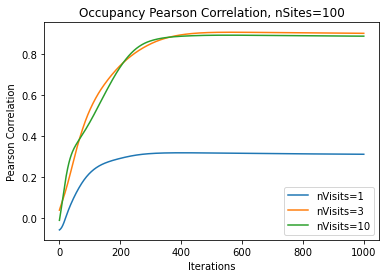

In [14]:
nSites = 100
nVisits = 1
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Occupancy Pearson Correlation, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

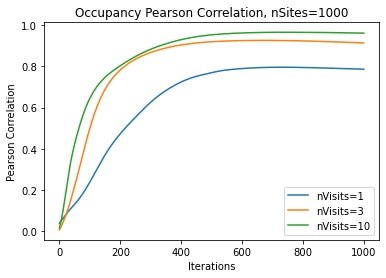

In [15]:
nSites = 1000
nVisits = 1
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(occCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Occupancy Pearson Correlation, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

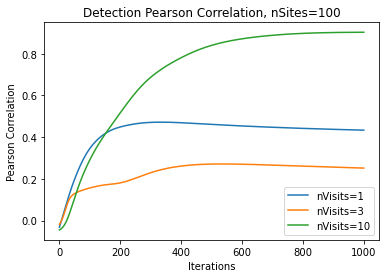

In [16]:
nSites = 100
nVisits = 1
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Detection Pearson Correlation, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

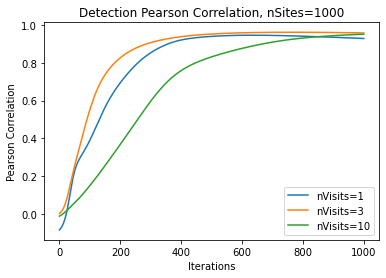

In [17]:
nSites = 1000
nVisits = 1
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(detCorr_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Detection Pearson Correlation, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Pearson Correlation")
plt.legend(loc='lower right')

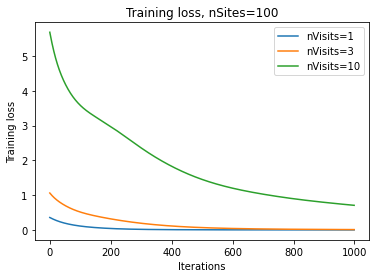

In [18]:
nSites = 100
nVisits = 1
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Training loss, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Training loss")
plt.legend(loc='upper right')

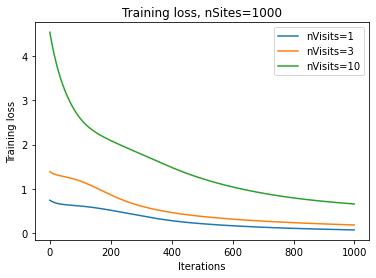

In [19]:
nSites = 1000
nVisits = 1
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 3
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))
nVisits = 10
plt.plot(train_loss_dic[(nSites, nVisits)], label='nVisits='+str(nVisits))

plt.title("Training loss, nSites=" + str(nSites))
plt.xlabel("Iterations")
plt.ylabel("Training loss")
plt.legend(loc='upper right')